Devoir #3 
Entraînement d'un PMC, d'un réseau de neurones profond de type CNN et transfert d'apprentissage 

Mercier Anna-Eve

2.1

In [60]:
import numpy as np 
import os
import pandas as pd

#Model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#Metruc and split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns



from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, recall_score, precision_score, f1_score, make_scorer, roc_curve, auc, accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
pd.options.mode.chained_assignment = None

In [ ]:
filepath_dataset = "dataset"

customer = "Customer.csv"
country_pop = "CountryPopulation.csv"
country_gdp = "CountryGDP.csv"

test_train_ratio = 0.2
random_state_seed = 42

sans_merge = False
merge_gdp = False

In [32]:
#### Fonction de bornage des données aberrantes (outliers)
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns

    #Calcul de l'écart interquartile
    Q25 = df[cols].quantile(0.25)  #Q1 on définit le premier quartile pour c
    Q75 = df[cols].quantile(0.75)
    IQR = Q75 - Q25

    #Calcul des bornages inférieurs et supérieurs à l'IQR
    SeuilMin = (Q25 - 1.5 * IQR)
    SeuilMax = (Q75 + 1.5 * IQR)

    # Remplacer les outliers à l'extérieur des bornes IQR par les valeurs correspondantes
    nouv_df = df[cols].clip(SeuilMin[cols], SeuilMax[cols], axis=1)
    return nouv_df

def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))

#### Fonction de concaténation (merge) des ensembles de données
def mergeDataset(data, pop=False, pib=False):
    # S'assurer que c'est bien un DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    # Cas sans merge
    if pop:
        return data

    # Fusion avec data_pays
    data_enrichie = pd.merge(data, data_pays, on='country', how='left')

    # Si PIB demandé
    if pib:
        data_enrichie = data_enrichie.merge(data_pib, on='country', how='left')

    return data_enrichie

#### Fonction de conversion de caractéristiques au format numérique
def toNum(data: pd.DataFrame):
    data['first_item_prize'] = pd.to_numeric(data['first_item_prize'])
    return data

### Pipeline de traitement des données numériques
num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, validate=False)),
    # Nettoyage par remplacement de valeurs manquantes
    ('imputer', SimpleImputer(strategy="median")),
    # Remplacement des données aberrantes
    ('clamp', FunctionTransformer(bornage, validate=False))
])

### Pipeline de traitement des données catégorielles
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Pipeline de tranformation des données numériques et catégorielles
preparationData = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

### Pipeline complet
full_pipeline = Pipeline([
    ('preparation', preparationData),
    ('standard_scaler', StandardScaler())
])

In [ ]:
data_client = pd.read_csv(os.path.join(filepath_dataset, customer), na_values=['?', 'unknown'])

data_pays = pd.read_csv(os.path.join(filepath_dataset, country_pop), na_values=['?', 'unknown'])
data_pays.columns = ['country', 'population']

data_pib = pd.read_csv(os.path.join(filepath_dataset, country_gdp), na_values=['?', 'unknown'])
data_pib.columns = ['country', 'GDP_inhab']

In [ ]:
df_merged = pd.merge(data_client, data_pays, on='country', how='left')
customer = pd.merge(df_merged, data_pib, on='country', how='left')

print(customer.info())
print(customer.head())
print(customer.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10000 non-null  float64
 1   pages             10000 non-null  float64
 2   first_item_prize  9997 non-null   float64
 3   gender            10000 non-null  object 
 4   ReBuy             10000 non-null  bool   
 5   News_click        10000 non-null  float64
 6   country           10000 non-null  object 
 7   revenue           9996 non-null   float64
 8   population        10000 non-null  int64  
 9   GDP_inhab         10000 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 713.0+ KB
None
    age  pages  first_item_prize gender  ReBuy  News_click country  revenue  \
0  41.0    6.0              28.0    Fem  False         4.0   China    113.0   
1  34.0    4.0              15.5    Fem   True         2.0   China     36.0   
2  38.0    5.

In [ ]:
#customer['Target']=np.where(customer['revenue']>customer['revenue'].mean(), 1, 0)

In [ ]:
customer_transformed = full_pipeline.fit_transform(customer)

cat_cols = full_pipeline.named_steps['preparation'] \
    .named_transformers_['cat']['encoder'].get_feature_names_out(
        customer.select_dtypes(exclude=np.number).columns
    )

num_cols = customer.select_dtypes(include=np.number).columns
columns = np.concatenate([num_cols, cat_cols])
customer = pd.DataFrame(customer_transformed, columns=columns)


In [ ]:
X = customer.drop(columns=['revenue'])
y = customer['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [66]:
model = MLPClassifier()

param_distributions = {
    'hidden_layer_sizes': [
    # --- 1 couche ---
    (10,), (25,), (50,), (75,), (100,),
    
    # --- 2 couches ---
    (10,10), (25,25), (50,50), (75,75), (100,100),
    (20,10), (50,25), (100,50), (75,25), (100,10),
    
    # --- 3 couches ---
    (10,10,10), (25,25,25), (50,50,50), (75,75,75), (100,100,100),
    (20,10,5), (50,25,10), (100,50,25), (75,50,25), (100,75,50),
    
    # --- 4 couches ---
    (100,50,25,10), (75,50,25,10), (50,25,10,5), 
    (100,75,50,25), (50,50,25,10), (100,50,10,50),
    
    # --- 5 couches ---
    (100,75,50,25,10), (50,50,25,10,5), (75,50,25,10,5),
    (100,50,25,10,50), (50,25,10,25,50), (50,50,10,100,100)],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'max_iter': [200, 500, 800]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=200,  # Number of parameter settings to sample
    scoring='accuracy',
    cv=3,  # Number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)


# For 2 classes
bins_2 = [-np.inf, 0, np.inf]
labels_2 = [0, 1]

y_train_2 = pd.cut(y_train, bins=bins_2, labels=labels_2)
y_test_2 = pd.cut(y_test, bins=bins_2, labels=labels_2)

random_search.fit(X_train,  y_train_2)

results_2 = pd.DataFrame(random_search.cv_results_)
print(results_2[['params', 'mean_test_score', 'rank_test_score']])

print("Best Parameters 2 class:", random_search.best_params_)
best_model_2 = random_search.best_estimator_
accuracy_2 = best_model_2.score(X_test, y_test_2)
print("Test Set Accuracy 2 class:", accuracy_2)




# For 3 classes
bins_3 = [-np.inf, -1, 0, np.inf]
labels_3 = ['bas', 'moyen', 'émevé']

y_train_3 = pd.cut(y_train, bins=bins_3, labels=labels_3)
y_test_3 = pd.cut(y_test, bins=bins_3, labels=labels_3)

random_search.fit(X_train,  y_train_3)

results_3 = pd.DataFrame(random_search.cv_results_)
print(results_3[['params', 'mean_test_score', 'rank_test_score']])

print("Best Parameters 3 class:", random_search.best_params_)
best_model_3 = random_search.best_estimator_
accuracy_3 = best_model_3.score(X_test, y_test_3)
print("Test Set Accuracy 3 class:", accuracy_3)


Fitting 3 folds for each of 200 candidates, totalling 600 fits


c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                                                params  mean_test_score  \
0    {'solver': 'sgd', 'max_iter': 800, 'learning_r...         0.799376   
1    {'solver': 'lbfgs', 'max_iter': 500, 'learning...         0.786375   
2    {'solver': 'adam', 'max_iter': 200, 'learning_...         0.828374   
3    {'solver': 'adam', 'max_iter': 500, 'learning_...         0.752981   
4    {'solver': 'adam', 'max_iter': 800, 'learning_...         0.822124   
..                                                 ...              ...   
195  {'solver': 'adam', 'max_iter': 800, 'learning_...         0.803125   
196  {'solver': 'adam', 'max_iter': 500, 'learning_...         0.799251   
197  {'solver': 'sgd', 'max_iter': 800, 'learning_r...         0.802749   
198  {'solver': 'sgd', 'max_iter': 500, 'learning_r...         0.599875   
199  {'solver': 'adam', 'max_iter': 200, 'learning_...         0.805499   

     rank_test_score  
0                107  
1                155  
2                 16  
3      

c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

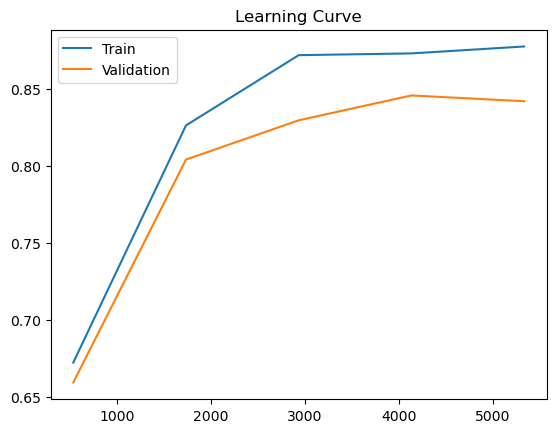

In [68]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_2, X_train, y_train_2, cv=3)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.legend()
plt.title("Learning Curve")
plt.show()


c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

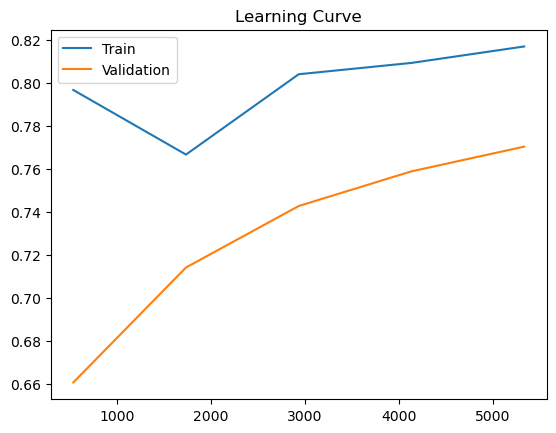

In [69]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_3, X_train, y_train_3, cv=3)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.legend()
plt.title("Learning Curve")
plt.show()


In [70]:
# For 2 classes
y_pred_2 = best_model_2.predict(X_test)

matrix_2 = confusion_matrix(y_test_2, y_pred_2)
print("Confusion Matrix:")
print(matrix_2)

report_2 = classification_report(y_test_2, y_pred_2)
print("Classification Report:")
print(report_2)


# For 3 classes
y_pred_3 = best_model_3.predict(X_test)


matrix_3 = confusion_matrix(y_test_3, y_pred_3)
print("Confusion Matrix:")
print(matrix_3)


report_3 = classification_report(y_test_3, y_pred_3)
print("Classification Report:")
print(report_3)



Confusion Matrix:
[[1043  178]
 [ 106  673]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1221
           1       0.79      0.86      0.83       779

    accuracy                           0.86      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.86      0.86      0.86      2000

Confusion Matrix:
[[161 108   5]
 [ 54 711 182]
 [  0 111 668]]
Classification Report:
              precision    recall  f1-score   support

         bas       0.75      0.59      0.66       274
       moyen       0.76      0.75      0.76       947
       émevé       0.78      0.86      0.82       779

    accuracy                           0.77      2000
   macro avg       0.76      0.73      0.74      2000
weighted avg       0.77      0.77      0.77      2000



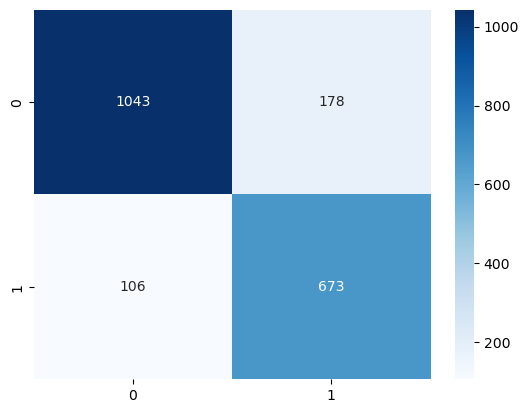

In [71]:
#For 2 classes
sns.heatmap(matrix_2, annot=True, fmt='d', cmap='Blues')
plt.show()

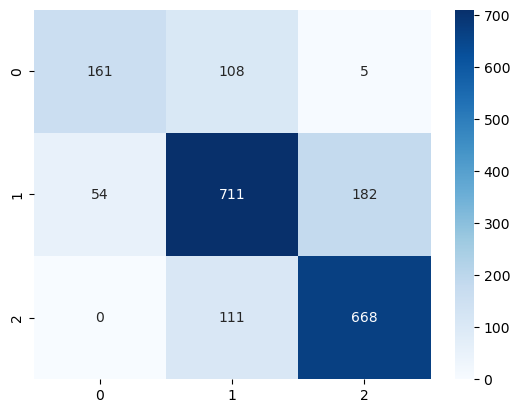

In [72]:
#for 3 classes
sns.heatmap(matrix_3, annot=True, fmt='d', cmap='Blues')
plt.show()